In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#Run a linear regression model on PCA_Dataset_With_Mean and GoogleTrendsTimelineCleaned
#load data
pca_dataset = pd.read_csv('./Data/PCA_Dataset_With_Mean.csv',index_col = 0)
gtrends = pd.read_csv('./Data/GoogleTrendsCleaned.csv', index_col=0)

In [3]:
pca_dataset.index = pd.to_datetime(pca_dataset.index)
gtrends.index = pd.to_datetime(gtrends.index)


In [4]:
pca_dataset = pd.DataFrame(pca_dataset['PCA_mean'])
pca_dataset

,PCA_mean
Date,
2018-10-07,1.254750
2018-10-14,2.054040
2018-10-21,1.407196
2018-10-28,0.951141
2018-11-04,1.020075
...,...
2021-06-27,1.845474
2021-07-04,1.763994
2021-07-11,1.498085


In [5]:
gtrends.index.rename('Date', inplace = True)

[Text(0, 0.5, 'Cryptocurrency_gs'),
 Text(0, 1.5, 'Bitcoin_gs'),
 Text(0, 2.5, 'Ethereum_gs'),
 Text(0, 3.5, 'XRP_gs'),
 Text(0, 4.5, 'Dogecoin_gs')]

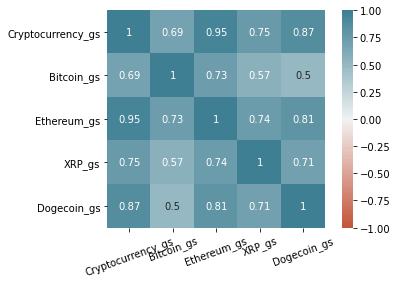

In [6]:
#Check for colinearity in google trends dataset

corr = gtrends.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation =0)

In [7]:
#This data is highly correlated. We need to decorrelate these columns. 

In [8]:
gtrends.drop('Cryptocurrency_gs', axis = 1, inplace = True)

gtrends['Ether_Doge_gs'] = (gtrends['Ethereum_gs'] + gtrends['Dogecoin_gs'])/2
gtrends.drop(['Ethereum_gs','Dogecoin_gs'],axis = 1, inplace = True)

[Text(0, 0.5, 'Bitcoin_gs'),
 Text(0, 1.5, 'XRP_gs'),
 Text(0, 2.5, 'Ether_Doge_gs')]

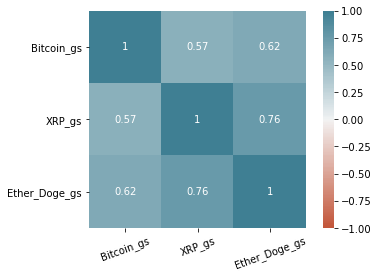

In [9]:
corr = gtrends.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation =0)

In [10]:
trends_price = gtrends.merge(pca_dataset, on='Date', left_index = True)

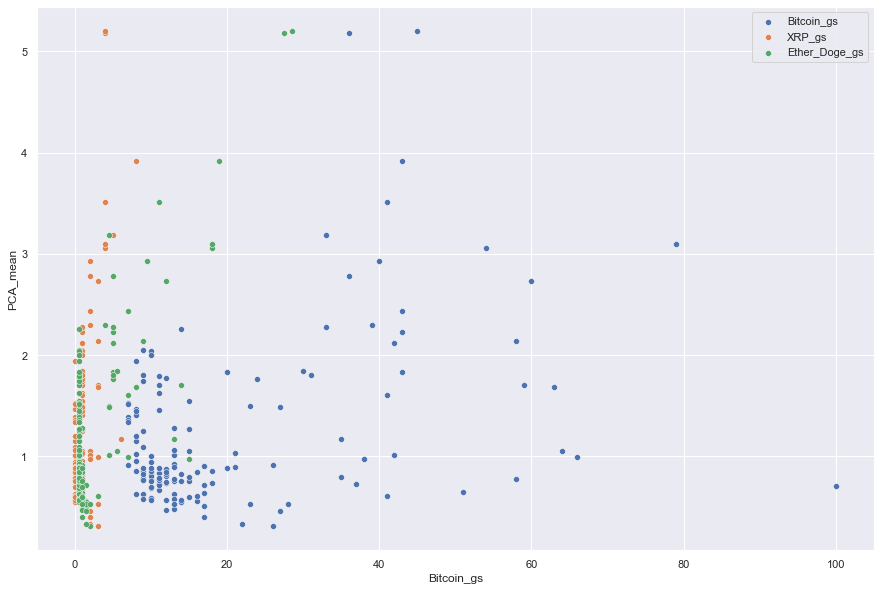

In [11]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x=trends_price['Bitcoin_gs'],y=trends_price['PCA_mean'])
sns.scatterplot(x=trends_price['XRP_gs'],y=trends_price['PCA_mean'])
sns.scatterplot(x=trends_price['Ether_Doge_gs'],y=trends_price['PCA_mean'])
plt.legend(labels=['Bitcoin_gs', 'XRP_gs' ,'Ether_Doge_gs'])
plt.show()

In [12]:
trends_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147 entries, 2018-10-07 to 2021-07-25
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Bitcoin_gs     147 non-null    int64  
 1   XRP_gs         147 non-null    int64  
 2   Ether_Doge_gs  147 non-null    float64
 3   PCA_mean       147 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 5.7 KB


In [13]:
#Create Manual Cross Validate Train Test Spilt
crossval_rsq = []
crossval_train_MSE = []
crossval_test_MSE = []
splits = [.25, .50 ,.75]

X = trends_price.drop('PCA_mean',axis = 1)
y = trends_price['PCA_mean']

for size in splits:
    #length of train and test split
    train_split = int(len(trends_price )* size)  
    test_split = int(len(trends_price)*(size + .25)) 
    
    #create training and test set
    X_train = X.iloc[:train_split]
    X_test = X.iloc[train_split:test_split]
    y_train = y.iloc[:train_split]
    y_test = y.iloc[train_split:test_split]
    
    #fit the regression on training set
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    
    #predict on training and test set to compare MSE
    y_pred_test=reg.predict(X_test)
    y_pred_train = reg.predict(X_train)
    
    #append scores to a list
    crossval_rsq.append(round(reg.score(X_train, y_train),3))
    crossval_train_MSE.append(round(mean_squared_error(y_train, y_pred_train),3))
    crossval_test_MSE.append(round(mean_squared_error(y_test, y_pred_test),3))


    
print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq, np.mean(crossval_rsq)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE, np.mean(crossval_train_MSE)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE, np.mean(crossval_test_MSE)))

rsq: [0.146, 0.142, 0.249]  
Mean rsq: 0.179

train MSE: [0.154, 0.16, 0.124] 
Mean Train MSE: 0.146

test MSE: [0.817, 0.059, 52.891] 
Mean Test MSE: 17.922


In [14]:
#Test results using Timeseriessplit
crossval_rsq = []
crossval_train_MSE = []
crossval_test_MSE= []

X = trends_price.drop('PCA_mean',axis = 1)
y = trends_price['PCA_mean']

tss = TimeSeriesSplit(n_splits = 3)

for train_index, test_index in tss.split(X):
    #create training and test set
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #fit the regressor
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    
    #predict on test and training set
    y_pred_test=   reg.predict(X_test)
    y_pred_train = reg.predict(X_train)
    
    #append scores to list
    crossval_rsq.append(round(reg.score(X_train, y_train),3))
    crossval_train_MSE.append(round(mean_squared_error(y_train, y_pred_train),3))
    crossval_test_MSE.append(round(mean_squared_error(y_test, y_pred_test),3))
    
print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq, np.mean(crossval_rsq)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE, np.mean(crossval_train_MSE)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE, np.mean(crossval_test_MSE)))
    

rsq: [0.2, 0.143, 0.252]  
Mean rsq: 0.198

train MSE: [0.147, 0.157, 0.123] 
Mean Train MSE: 0.142

test MSE: [1.247, 0.061, 56.653] 
Mean Test MSE: 19.320


Crossvalidation scores for each method are roughly similar. We can use our TimeSeriesSplit cross validation results for our analysis 

Our model is roughly 20% accurate. 
With a mean MSE of 0.14 on the training set and a mean MSE of 19 on the test set. Our model is predicting poorly on the test set as the variance of our MSE is huge. 

In [15]:
#Stats Model
import statsmodels.api as sm

X2 = sm.add_constant(X)

regstats = sm.OLS(y,X2)
stats= regstats.fit()
pred = stats.predict()

In [16]:
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PCA_mean   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     72.65
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.32e-28
Time:                        11:52:37   Log-Likelihood:                -112.44
No. Observations:                 147   AIC:                             232.9
Df Residuals:                     143   BIC:                             244.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9466      0.072     13.184      0.000       0.805       1.089
Bitcoin_gs       -0.0059      0.003     -1.717      0.088      -0.013       0.001
XRP_gs            0.0524      0.053      0.980      0.329      -0.053       0.158
Ether_Doge_gs     0.1368      0.015      9.109      0.000       0.107       0.167
==============================================================================
Omnibus:                        7.329   Durbin-Watson:                   0.474
Prob(Omnibus):                  0.026   Jarque-Bera (JB):               12.292
Skew:                           0.143   Prob(JB):                      0.00214
Kurtosis:                       4.387   Cond. No.                         45.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 2 - Random Forest with GridSearchCV

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

#Remake X, y test spilt based on all Google trends
X = trends_price.drop('PCA_mean',axis =1)
y = trends_price['PCA_mean']

#Make a rolling training set and test set and cross validate manually
crossval_rsq_rf = []
crossval_train_MSE_rf = []
crossval_test_MSE_rf = []

cv = []

rf_pipe = make_pipeline(
RandomForestRegressor())

max_features = ['auto', 'sqrt']
n_est = np.arange(start = 1, stop = 100, step = 2)

grid_params = {
    'randomforestregressor__n_estimators': n_est,
    'randomforestregressor__max_features':max_features
}

#Create the cv indices
for size in splits:
    train_split = int(len(trends_price )* size)  
    test_split = int(len(trends_price)*(size + .25)) 
    
    cv.append((np.arange(train_split),np.arange(train_split,test_split)))

#Use Gridsearchcv on custom cv splits    
rf_grid = GridSearchCV(rf_pipe, param_grid=grid_params, cv = cv, n_jobs=-1)    
rf_grid.fit(X,y)

print(rf_grid.best_params_)

#Use best estimator model
rf_model = rf_grid.best_estimator_

#Fit model on the training and test set with best parameters
for train,test in cv:

    X_train = X.iloc[train]
    X_test = X.iloc[test]
    
    y_train = y.iloc[train]
    y_test = y.iloc[test]

    rf_model.fit(X_train, y_train)
    #predict on train and test set
    y_pred_train = rf_model.predict(X_train) 
    y_pred_test = rf_model.predict(X_test) 
    
    crossval_rsq_rf.append(round(rf_model.score(X_train, y_train),3))
    crossval_train_MSE_rf.append(round(mean_squared_error(y_train, y_pred_train),3))
    crossval_test_MSE_rf.append(round(mean_squared_error(y_test, y_pred_test),3))


print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq_rf, np.mean(crossval_rsq_rf)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE_rf, np.mean(crossval_train_MSE_rf)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE_rf, np.mean(crossval_test_MSE_rf)))


{'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 19}
rsq: [0.491, 0.357, 0.458]  
Mean rsq: 0.435

train MSE: [0.092, 0.12, 0.089] 
Mean Train MSE: 0.100

test MSE: [0.371, 0.124, 3.293] 
Mean Test MSE: 1.263


In [18]:
#Double check our results using TimeSeriesSplit

crossval_rsq_rf = []
crossval_train_MSE_rf = []
crossval_test_MSE_rf = []

X = trends_price.drop('PCA_mean',axis = 1)
y = trends_price['PCA_mean']
tss = TimeSeriesSplit(n_splits = 3)
    
#Call Gridsearchcv with custom split
rf_grid = GridSearchCV(rf_pipe, param_grid=grid_params, cv = tss.split(X), n_jobs=-1)    

rf_grid.fit(X,y)

print(rf_grid.best_params_)

rf_model = rf_grid.best_estimator_

#Fit model on training and test set with best parameters 

for train_index, test_index in tss.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_model.fit(X_train, y_train)

    #predict on train and test set
    y_pred_train = rf_model.predict(X_train) 
    y_pred_test = rf_model.predict(X_test) 
    
    crossval_rsq_rf.append(round(rf_model.score(X_train, y_train),3))
    crossval_train_MSE_rf.append(round(mean_squared_error(y_train, y_pred_train),3))
    crossval_test_MSE_rf.append(round(mean_squared_error(y_test, y_pred_test),3))        
 
    
print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq_rf, np.mean(crossval_rsq_rf)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE_rf, np.mean(crossval_train_MSE_rf)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE_rf, np.mean(crossval_test_MSE_rf)))


{'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 19}
rsq: [0.544, 0.365, 0.473]  
Mean rsq: 0.461

train MSE: [0.084, 0.116, 0.087] 
Mean Train MSE: 0.096

test MSE: [0.333, 0.119, 3.259] 
Mean Test MSE: 1.237


## Random Forest Model Performance

Our model is muich stronger using the Random Forest Model. It is roughly 45% accurate with an average Train MSE of .1 and an average Test MSE of 1.186. While this model also has a bit of variance in the test MSE, it is not as big as our Linear Regression model 

## Random Forest Feature Importance

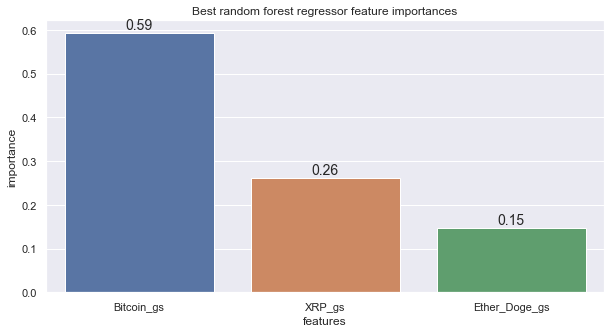

In [19]:
plt.subplots(figsize=(10, 5))

ax = plt.subplot()
imps = rf_grid.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
plots = sns.barplot(x = rf_feat_imps.index, y = rf_feat_imps)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=14, xytext=(0, 8),
                   textcoords='offset points')

Bitcoin_gs is the most important feature that impacts the price of cryptocurrencies, after that is a sharp decline with Dogecoin/Ethereum and XRP each with 20% feature importance. 

## Model #3 - Ridge Regression 

Since our Independent variables are correlated with each other. Lets use Ridge Regression model and see how it performs

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


#Make a rolling training set and test set and cross validate manually
crossval_rsq_rr = []
crossval_train_MSE_rr = []
crossval_test_MSE_rr = []

cv = []

rr_pipe = make_pipeline(
    Ridge())

grid_params = {
        'ridge__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
}

for size in splits:
    train_split = int(len(trends_price )* size)  
    test_split = int(len(trends_price)*(size + .25)) 
    
    cv.append((np.arange(train_split),np.arange(train_split,test_split)))
    
    
rr_grid= GridSearchCV(rr_pipe, grid_params,cv=cv,n_jobs = -1)

rr_grid.fit(X,y)

print(rr_grid.best_params_)

rr_model = rr_grid.best_estimator_

#Fit model on the training and test set with best parameters
for train,test in cv:

    X_train = X.iloc[train]
    X_test = X.iloc[test]
    
    y_train = y.iloc[train]
    y_test = y.iloc[test]

    rr_model.fit(X_train, y_train)

    y_pred_train = rr_model.predict(X_train) 
    y_pred_test = rr_model.predict(X_test) 
    
    crossval_rsq_rr.append(round(rr_model.score(X_train, y_train),3))
    crossval_train_MSE_rr.append(round(mean_squared_error(y_train, y_pred_train),3))
    crossval_test_MSE_rr.append(round(mean_squared_error(y_test, y_pred_test),3))


print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq_rr, np.mean(crossval_rsq_rr)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE_rr, np.mean(crossval_train_MSE_rr)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE_rr, np.mean(crossval_test_MSE_rr)))


{'ridge__alpha': 20}
rsq: [0.074, 0.095, 0.149]  
Mean rsq: 0.106

train MSE: [0.167, 0.169, 0.14] 
Mean Train MSE: 0.159

test MSE: [0.355, 0.136, 8.29] 
Mean Test MSE: 2.927


In [21]:
#Double Check results from TimeSeriesSplit

crossval_rsq_rr = []
crossval_train_MSE_rr = []
crossval_test_MSE_rr = []

tss = TimeSeriesSplit(n_splits = 3)
    
rr_grid = GridSearchCV(rr_pipe, param_grid=grid_params, cv = tss.split(X), n_jobs=-1)
    

rr_grid.fit(X,y)
print(rr_grid.best_params_)

rr_model = rr_grid.best_estimator_

#Fit model on training and test set with best parameters 

for train_index, test_index in tss.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rr_model.fit(X_train, y_train)

    y_pred_train = rr_model.predict(X_train) 
    y_pred_test = rr_model.predict(X_test) 
    
    crossval_rsq_rr.append(round(rr_model.score(X_train, y_train),3))
    crossval_train_MSE_rr.append(round(mean_squared_error(y_train, y_pred_train),3))
    crossval_test_MSE_rr.append(round(mean_squared_error(y_test, y_pred_test),3))        
 
    
print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq_rr, np.mean(crossval_rsq_rr)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE_rr, np.mean(crossval_train_MSE_rr)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE_rr, np.mean(crossval_test_MSE_rr)))

{'ridge__alpha': 20}
rsq: [0.135, 0.096, 0.15]  
Mean rsq: 0.127

train MSE: [0.159, 0.165, 0.14] 
Mean Train MSE: 0.155

test MSE: [0.472, 0.142, 8.912] 
Mean Test MSE: 3.175


## Ridge Regression Model Performance

Our model is roughly 12.7% accurate. Our Train MSE is 0.155 and our Test MSE is 3.175. 
This model performed the worst out of all three on  the rsq metric. And is in the middle for mean MSE score. 

## Finding the right model

Lets look at performance for linear regression and Random forest again

In [22]:
#Linear Regression Model Performance
print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq, np.mean(crossval_rsq)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE, np.mean(crossval_train_MSE)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE, np.mean(crossval_test_MSE)))

rsq: [0.2, 0.143, 0.252]  
Mean rsq: 0.198

train MSE: [0.147, 0.157, 0.123] 
Mean Train MSE: 0.142

test MSE: [1.247, 0.061, 56.653] 
Mean Test MSE: 19.320


In [23]:
#Random Forest Model Performance
print('rsq: {}  \nMean rsq: {:.3f}'.format(crossval_rsq_rf, np.mean(crossval_rsq_rf)))
print('\ntrain MSE: {} \nMean Train MSE: {:.3f}'.format(crossval_train_MSE_rf, np.mean(crossval_train_MSE_rf)))
print('\ntest MSE: {} \nMean Test MSE: {:.3f}'.format(crossval_test_MSE_rf, np.mean(crossval_test_MSE_rf)))

rsq: [0.544, 0.365, 0.473]  
Mean rsq: 0.461

train MSE: [0.084, 0.116, 0.087] 
Mean Train MSE: 0.096

test MSE: [0.333, 0.119, 3.259] 
Mean Test MSE: 1.237


Random Forest has the highest mean r2 score and the lowest mean MSE. 

We will use random forest as our model for this problem